In [11]:
import jax.numpy as jnp
import jax
import cryojax as cx
import simple_simulator as sim
import os

import numpyro
import numpyro.distributions as dist

import logging
from functools import partial



# Create list of pdb files, and define a list of default conformation weights

In [12]:
path_to_models="data/hsp90_models"
model_fnames = []
for model_fname in sorted(os.listdir(path_to_models)):
    model_fnames.append(model_fname)

# Define weights: for now, just a constant vector
default_weights = (1/len(model_fnames))*jnp.ones(len(model_fnames))


# Define a config file

In [13]:
# Bare bones config for this notebook
# Things that may need to be adjusted:
#   number of images, noise_snr
# Everything else, unlikely
config = {
"number_of_images": 10,
"noise_snr": 0.1,
"weights_models": default_weights,
"models_fnames": model_fnames, 
"path_to_models": path_to_models, 
"box_size": 128,
"rng_seed": 0,
"pixel_size": 1.6,
}

### Create inputs for generating noise

In [14]:
# Create static image formation stuff
imaging_args = sim.build_image_formation_stuff(config)

# Create noise stuff
noise_grid = jnp.linspace(
                 -0.5 * (config["box_size"] - 1),
                 0.5 * (config["box_size"] - 1),
                 config["box_size"],
             )
noise_radius = 0.5*config["box_size"] - 1 # For now, using a disc that is radius of the image for SNR calculations
noise_args = noise_grid, noise_radius, config["noise_snr"] 



### Custom functions for these simulation purposes

In [15]:
def get_pipeline_info(imaging_pipeline):
    """Custom function for returning various stats from an imaging pipeline"""
    info = {}
    info["conformation"] = imaging_pipeline.scattering_theory.structural_ensemble.conformation.value  
    #info["..."] = ...

    return info

def sample_images(key, config, imaging_args, noise_args, weights=None):

    # NOTE: for now just replacing default weights with user input weights
    if weights is not None:
        imaging_args["weights"] = weights

    # Generate RNG keys for individual images
    key, *subkeys = jax.random.split(key, config["number_of_images"] + 1)
    subkeys = jnp.array(subkeys)
    
    # Pipeline
    imaging_pipeline = sim.make_imaging_pipeline(subkeys, imaging_args)
    extra_info = get_pipeline_info(imaging_pipeline)

    noised_images, noise_power_sq = sim.compute_image_stack_with_noise(key, config, imaging_pipeline, noise_args)
    return noised_images, extra_info



## Define probability distribution over weight vectors
In this case, using a "flat" dirichlet prior on the simplex, which samples uniformly from the simplex

In [16]:
weights_dist = dist.Dirichlet(jnp.ones(len(model_fnames)))

# Simulate a dataset!

In [17]:
number_of_simulations = 20
key = jax.random.PRNGKey(config["rng_seed"])
key, *subkeys = jax.random.split(key, number_of_simulations + 1)

list_of_sims = []
for subkey in subkeys:
    weights = weights_dist.sample(subkey)
    noised_images, extra_info = sample_images(subkey,config, imaging_args, noise_args, weights)
    list_of_sims.append(([noised_images, extra_info, weights]))


showing images from a couple of the simulations


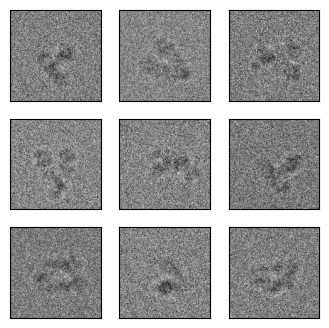

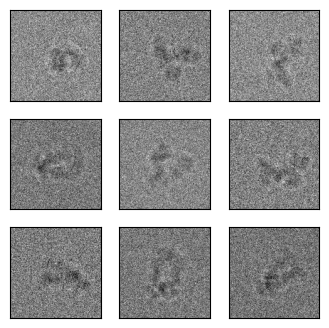

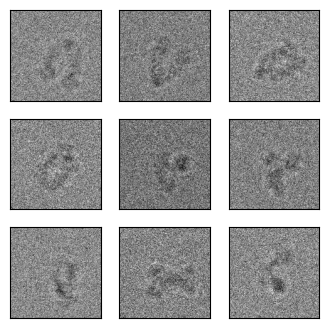

In [18]:
import matplotlib.pyplot as plt
#print(images.shape)
#for i in range(10):
#    plt.figure()
#    plt.imshow(images[i], cmap="gray")

print("showing images from a couple of the simulations")
num_plots = jnp.minimum(number_of_simulations, 3)
for i in range(num_plots):
    fig, axes = plt.subplots(3, 3, figsize=(4, 4))
    for idx, ax in enumerate(axes.reshape(-1)):
        ax.imshow(list_of_sims[i][0][idx,:], cmap="gray")
        ax.set_yticks([])
        ax.set_xticks([])
    #plt.savefig(f"figures/noised_images", dpi=300)


# Plotting distribution of weight vectors
NOTE: this should be the dirichlet distribution indicated at beginning of document
This plot isn't very informative, just making sure something isn't horribly wrong

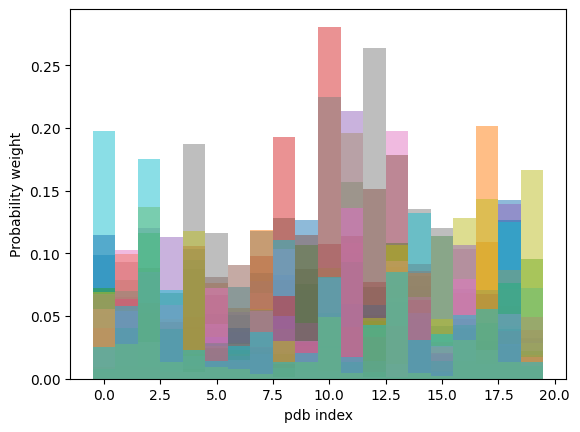

In [19]:
plt.figure()
for i in range(number_of_simulations):
    weights = list_of_sims[i][2]
    plt.bar(x=jnp.arange(0, 20), height=weights, width=1, alpha=0.5)
    plt.xlabel("pdb index")
    plt.ylabel("Probability weight")